# CAISO Cluster 15 – Survivability Insights

This notebook analyzes survivability patterns in CAISO Cluster 15 interconnection requests using cleaned datasets from:

- `public_queue_clean.csv` (system-wide context)
- `cluster15_clean.csv` (single-cohort analysis)

Focus:
- Withdrawal timing
- Technology and MW patterns
- Early vs late attrition dynamics

This is a retrospective, descriptive analysis (not prediction).

## 1) Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print('Python:', sys.version)
print('Executable:', sys.executable)


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Executable: C:\Users\danci\Interconnection-Queue-Intelligence\.venv\Scripts\python.exe


## 2) Paths + outputs folders

We create `outputs/figures/` and `outputs/tables/` so the final deliverables exist outside the notebook.
This makes it easy to reference results from the README and reuse figures in slides.

In [2]:
ROOT = Path.cwd()
if ROOT.name == 'notebooks':
    ROOT = ROOT.parent

PROCESSED = ROOT / 'data' / 'processed'
OUTPUTS = ROOT / 'outputs'
FIGURES = OUTPUTS / 'figures'
TABLES = OUTPUTS / 'tables'

FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print('ROOT:', ROOT)
print('Processed files:', [p.name for p in PROCESSED.glob('*')])
print('Figures dir:', FIGURES)
print('Tables dir:', TABLES)


ROOT: C:\Users\danci\Interconnection-Queue-Intelligence
Processed files: ['cluster15_clean.csv', 'public_queue_clean.csv', '_cluster15_raw.csv', '_cluster15_withdrawn_raw.csv', '_public_queue_raw_parsed.csv']
Figures dir: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures
Tables dir: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables


## 3) Load cleaned datasets

These are produced by:
- `02_clean_public_queue.ipynb`
- `03_clean_cluster15.ipynb`

In [3]:
public = pd.read_csv(PROCESSED / 'public_queue_clean.csv')
cluster15 = pd.read_csv(PROCESSED / 'cluster15_clean.csv')

cluster15.shape, public.shape


((170, 18), (2285, 17))

## 4) Overall survivability in Cluster 15

In [4]:
cluster15['status'].value_counts()

status
active       108
withdrawn     62
Name: count, dtype: int64

### Figure: Cluster 15 outcomes (count)

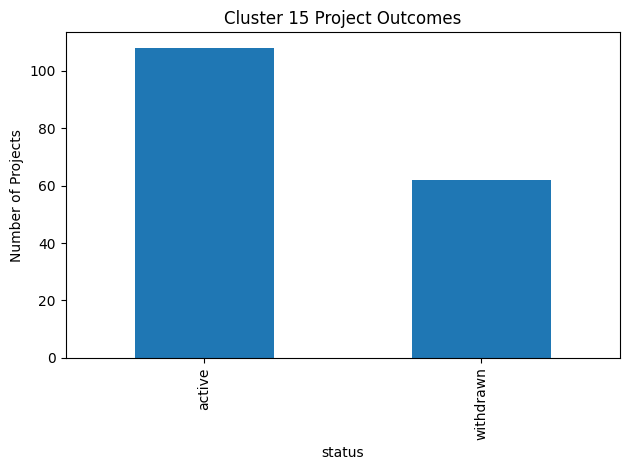

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_outcomes_bar.png


In [6]:
ax = cluster15['status'].value_counts().plot(
    kind='bar',
    title='Cluster 15 Project Outcomes',
    ylabel='Number of Projects'
)
plt.tight_layout()
plt.savefig(FIGURES / 'cluster15_outcomes_bar.png', dpi=200)
plt.show()

print('Saved:', FIGURES / 'cluster15_outcomes_bar.png')


## 5) When do projects withdraw?

We bucket withdrawn projects by time-to-withdrawal (queue entry → withdrawal).

In [7]:
withdrawn = cluster15[cluster15['status'] == 'withdrawn'].copy()

bins = [-1, 180, 365, 730, np.inf]
labels = ['<6 months', '6–12 months', '1–2 years', '>2 years']

withdrawn['withdrawal_timing'] = pd.cut(
    withdrawn['days_queue_to_withdrawal'],
    bins=bins,
    labels=labels
)

timing_counts = withdrawn['withdrawal_timing'].value_counts().sort_index()
timing_counts


withdrawal_timing
<6 months      25
6–12 months    37
1–2 years       0
>2 years        0
Name: count, dtype: int64

### Save: withdrawal timing table

In [8]:
timing_table = timing_counts.rename('count').to_frame()
timing_table['share'] = timing_table['count'] / timing_table['count'].sum()
timing_table.to_csv(TABLES / 'cluster15_withdrawal_timing_bins.csv')
timing_table

print('Saved:', TABLES / 'cluster15_withdrawal_timing_bins.csv')


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster15_withdrawal_timing_bins.csv


### Figure: withdrawal timing (count)

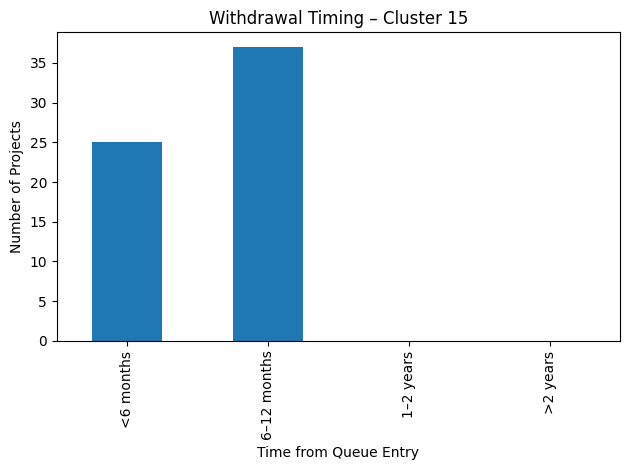

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_withdrawal_timing_bar.png


In [9]:
ax = timing_counts.plot(
    kind='bar',
    title='Withdrawal Timing – Cluster 15',
    ylabel='Number of Projects'
)
ax.set_xlabel('Time from Queue Entry')
plt.tight_layout()
plt.savefig(FIGURES / 'cluster15_withdrawal_timing_bar.png', dpi=200)
plt.show()

print('Saved:', FIGURES / 'cluster15_withdrawal_timing_bar.png')


## 6) Survivability by technology

We compare outcomes across simplified technology categories, both by project count and MW-weighted capacity.

In [10]:
tech_counts = (
    cluster15.groupby(['technology', 'status'])
    .size()
    .unstack(fill_value=0)
    .sort_values(by='withdrawn', ascending=False)
)
tech_counts


status,active,withdrawn
technology,,
storage,48,40
hybrid_solar_storage,39,17
solar,19,4
other,0,1
wind,2,0


### Save: technology outcome table (counts)

In [11]:
tech_counts.to_csv(TABLES / 'cluster15_survivability_by_technology_counts.csv')
print('Saved:', TABLES / 'cluster15_survivability_by_technology_counts.csv')


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster15_survivability_by_technology_counts.csv


In [12]:
tech_mw = (
    cluster15.groupby(['technology', 'status'])['net_mw']
    .sum()
    .unstack(fill_value=0)
    .sort_values(by='withdrawn', ascending=False)
)
tech_mw


status,active,withdrawn
technology,,
hybrid_solar_storage,29258.878740,16286.170973
storage,18205.191636,13829.871846
solar,5433.157620,826.476546
other,0.000000,11.400000
wind,417.100000,0.000000


### Save: technology outcome table (MW-weighted)

In [13]:
tech_mw.to_csv(TABLES / 'cluster15_survivability_by_technology_mw.csv')
print('Saved:', TABLES / 'cluster15_survivability_by_technology_mw.csv')


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster15_survivability_by_technology_mw.csv


### Figure: withdrawal rate by technology (count-based)

Note: this is **count-based** (not MW-weighted).

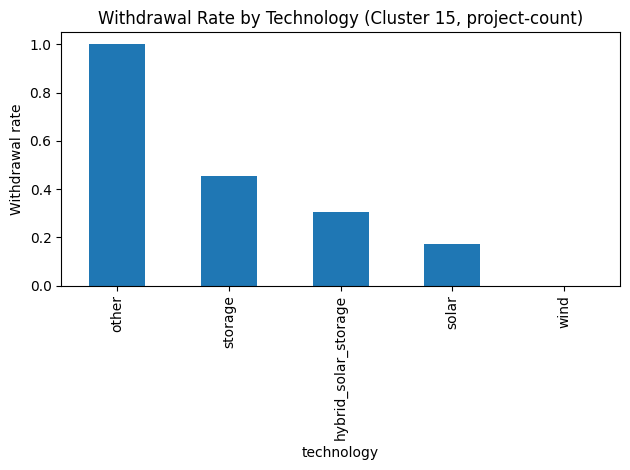

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_withdrawal_rate_by_technology.png


In [14]:
tech_rate = tech_counts.copy()
tech_rate['withdrawal_rate'] = tech_rate['withdrawn'] / (tech_rate['withdrawn'] + tech_rate['active'])

ax = tech_rate['withdrawal_rate'].sort_values(ascending=False).plot(
    kind='bar',
    title='Withdrawal Rate by Technology (Cluster 15, project-count)',
    ylabel='Withdrawal rate'
)
plt.tight_layout()
plt.savefig(FIGURES / 'cluster15_withdrawal_rate_by_technology.png', dpi=200)
plt.show()

print('Saved:', FIGURES / 'cluster15_withdrawal_rate_by_technology.png')


## 7) Project size and attrition

We bucket projects by size (net MW) and compute both counts and withdrawal rates.

In [15]:
cluster15['mw_bucket'] = pd.cut(
    cluster15['net_mw'],
    bins=[0, 20, 50, 100, np.inf],
    labels=['<20 MW', '20–50 MW', '50–100 MW', '100+ MW']
)

mw_outcomes = (
    cluster15.groupby(['mw_bucket', 'status'], observed=True)
    .size()
    .unstack(fill_value=0)
)

mw_outcomes['withdrawal_rate'] = mw_outcomes['withdrawn'] / (mw_outcomes['withdrawn'] + mw_outcomes['active'])
mw_outcomes


status,active,withdrawn,withdrawal_rate
mw_bucket,,,
<20 MW,1,3,0.750000
20–50 MW,0,1,1.000000
50–100 MW,3,3,0.500000
100+ MW,104,55,0.345912


### Save: MW bucket outcome table

In [16]:
mw_outcomes.to_csv(TABLES / 'cluster15_outcomes_by_mw_bucket.csv')
print('Saved:', TABLES / 'cluster15_outcomes_by_mw_bucket.csv')


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster15_outcomes_by_mw_bucket.csv


### Figure: withdrawal rate by MW bucket

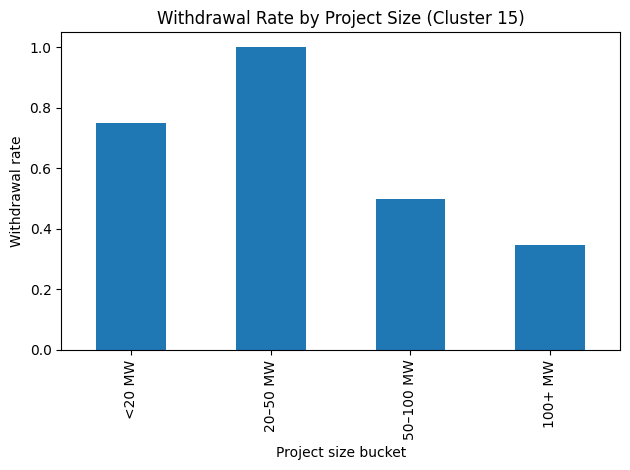

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\cluster15_withdrawal_rate_by_mw_bucket.png


In [17]:
ax = mw_outcomes['withdrawal_rate'].plot(
    kind='bar',
    title='Withdrawal Rate by Project Size (Cluster 15)',
    ylabel='Withdrawal rate'
)
ax.set_xlabel('Project size bucket')
plt.tight_layout()
plt.savefig(FIGURES / 'cluster15_withdrawal_rate_by_mw_bucket.png', dpi=200)
plt.show()

print('Saved:', FIGURES / 'cluster15_withdrawal_rate_by_mw_bucket.png')


## 8) Early vs late withdrawals

We compare technology composition for projects that withdraw within 1 year vs after 1 year.
If there are no late withdrawals in the current data slice, that result is still informative.

In [18]:
early = withdrawn[withdrawn['days_queue_to_withdrawal'] <= 365]
late = withdrawn[withdrawn['days_queue_to_withdrawal'] > 365]

early_late = pd.DataFrame({
    'early_withdrawals': early['technology'].value_counts(),
    'late_withdrawals': late['technology'].value_counts()
}).fillna(0)

early_late


,early_withdrawals,late_withdrawals
technology,,
hybrid_solar_storage,17,0.0
other,1,0.0
solar,4,0.0
storage,40,0.0


### Save: early vs late withdrawal table

In [19]:
early_late.to_csv(TABLES / 'cluster15_early_vs_late_withdrawals_by_technology.csv')
print('Saved:', TABLES / 'cluster15_early_vs_late_withdrawals_by_technology.csv')


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\cluster15_early_vs_late_withdrawals_by_technology.csv


## Key insights (summary)

- **Withdrawal is common** in the Cluster 15 cohort (relative to persistence).
- Withdrawals are **front-loaded**: the cohort’s withdrawn projects largely exit within the first year.
- **Technology mix matters**, but interpretation improves when considered alongside **project size**.
- Cluster 15 is dominated by **large (100+ MW) projects**, which show lower withdrawal rates than smaller buckets (small buckets have limited sample sizes).

## Limitations

- Cluster 15 public export does not include storage MWh in this version, so duration-based features are not analyzed.
- Results are retrospective and depend on the snapshot timing; active projects can withdraw later.

## Outputs

Final figures and tables are saved to:
- `outputs/figures/`
- `outputs/tables/`
